{'name': ['Boundaries', 'canopy_0.0', 'trunk_0.0'], 'type': ['scene', 'bbox', 'bbox'], 'normal': [], 'bounds': [[[0, 0, 0], [100, 100, 100]], [[16.666666666666664, 16.666666666666664, 20.0], [83.33333333333334, 83.33333333333334, 60.0]], [[45.0, 45.0, 0], [55.0, 55.0, 20.0]]]}


<IPython.core.display.Javascript object>


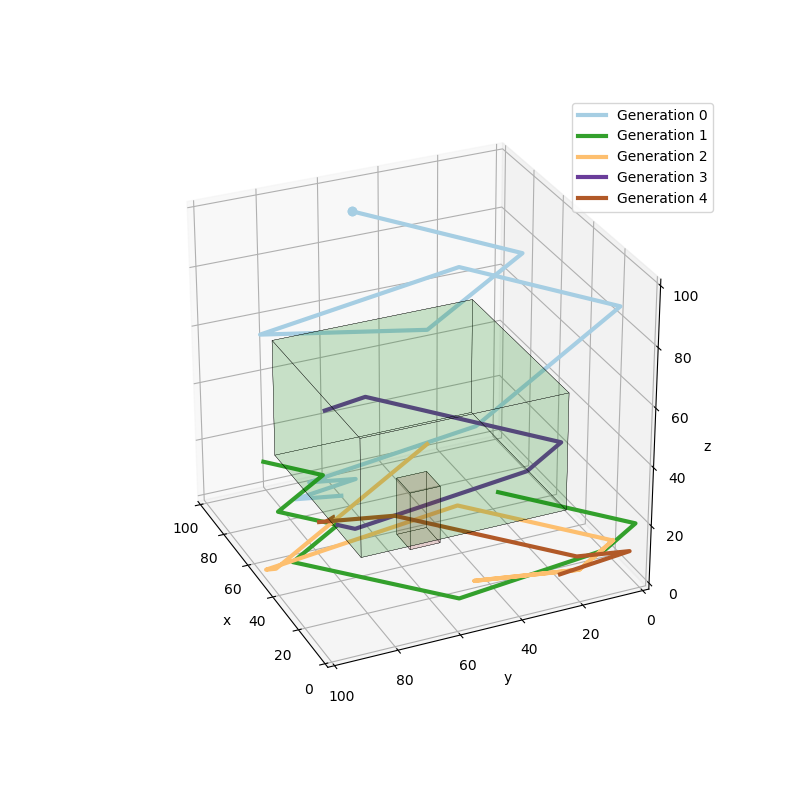

In [1]:
%matplotlib notebook
import plantrt as rt
import scene_conf as conf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from visualise import *

import numpy as np

pars = {'theta_sun':np.pi*.9,
        'phi_sun':2*np.pi/5,
        'nscat': 10,
       'scene_extent':[100,100,100],
       'logfile': 'out.log',
       'nplevels':3}


scene_extent = pars['scene_extent']

scene = conf.default_scene_elements(scene_extent)

print (scene)

idbox = np.where(np.array(scene['type']) == 'bbox')[0]
nboxes = len(idbox)

colors = {'canopy': 'green',
         'trunk': 'brown'}

fig = plt.figure(2,figsize=(8,8))
ax = fig.gca(projection='3d')

if nboxes == 0:
    print ('No bounding boxes found!')
else:
    for ibox in range(nboxes):
        idd  = idbox[ibox]
        size = [[(scene['bounds'][idd][1][x] - scene['bounds'][idd][0][x]) for x in range(3)]]
        pos  = [[(scene['bounds'][idd][1][x] + scene['bounds'][idd][0][x])/2. - size[0][x]/2.  for x in range(3)]]
        col  = [colors[scene['name'][idd].split('_')[0]]]
        #print (size)
        #print (pos)
        
        #size = [[10,10,10]]
        #pos  = [[10,10,10]]
        
        pc = plotCubeAt(pos, sizes=size, colors=col,edgecolor="k",linewidth=0.2,alpha=0.1)
        ax.add_collection3d(pc)


ax.set_xlim([0,scene_extent[0]])
ax.set_ylim([0,scene_extent[1]])
ax.set_zlim([0,scene_extent[2]])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
nscatter = pars['nscat']

In [2]:
nphotons,pos, scene = rt.run(pars, verbose=True)
print (nphotons)
print (pos[-1])


5
[array([30.96787849, 83.33333333, 33.3436854 ]), array([16.66666667, 39.31872913, 31.6191306 ]), array([70.46830451, 37.81152949, 20.        ]), array([42.63989874, 83.33333333, 56.11973783]), array([  7.78078311, 100.        ,  40.96230149])]


/home/aaorsi/work/PlantTech/PlantRT/plantrt.py:20: RuntimeWarning: divide by zero encountered in true_divide
  self.invdir = 1./self._dir


In [ ]:
%debug

In [3]:
print (len(pos))
pos[0] = [pos[0]]
lpos = [len(x) for x in pos]
print(lpos)
print (pos[0])

35
[1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[array([99, 50, 90])]


In [4]:
pos[0] 
lpos = np.array([len(x) for x in pos])
raycol = plt.cm.Paired(np.linspace(0,1,nphotons))

for ip in range(nphotons):
    sel = np.where(lpos >= ip+1)[0]
    nsel = len(sel)
    
    xpos = [pos[sel[i]][ip][0] for i in range(nsel)]
    ypos = [pos[sel[i]][ip][1] for i in range(nsel)]
    zpos = [pos[sel[i]][ip][2] for i in range(nsel)]

    ax.plot(xpos,ypos,zpos,color=raycol[ip],linewidth=3,label=f'Generation {ip}')
    if ip == 0:
        ax.plot([xpos[0], xpos[0]],[ypos[0],ypos[0]],
                [zpos[0],zpos[0]],color=raycol[ip],marker='o')
    a = Arrow3D([xpos[-2], xpos[-1]], [ypos[-2], ypos[-1]], 
                [zpos[-2], zpos[-1]], mutation_scale=20, 
                lw=1, arrowstyle="-|>",color=raycol[ip])
    ax.add_artist(a)
ax.legend()    

In [ ]:
%debug

In [ ]:
%matplotlib notebook 
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility

def update_lines(num, datalines, lines):
#    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
    i = 0
    for data, line in zip(datalines, lines):
        if i == 0:
            orig = 0 if num < 1 else num-1
            end = num
        else:
            orig = 0 if num < (3+i*2) else num-(3+i*2)
            end = num if num < 2 else num-1
        line.set_data(data[0:2, orig:end])
        line.set_3d_properties(data[2, orig:end])
        if i == 0:
            line.set_marker('*')
        else:
            line.set_alpha(0.4-i/20.0)
            
        line.set_linewidth(2)
        line.set_color('orange')
        i += 1
    ax.view_init(elev=10.+30*np.sin(num/100.0), azim=num*0.2)
    return lines

# Attaching 3D axis to the figure
fig = plt.figure(123,figsize=(5,5))
ax = p3.Axes3D(fig)
#ax.set_aspect('equal')



scene = conf.default_scene_elements(scene_extent)

idbox = np.where(np.array(scene['type']) == 'bbox')[0]
nboxes = len(idbox)

colors = {'canopy': 'green',
         'trunk': 'brown'}


if nboxes == 0:
    print ('No bounding boxes found!')
else:
    for ibox in range(nboxes):
        idd  = idbox[ibox]
        size = [[(scene['bounds'][idd][1][x] - scene['bounds'][idd][0][x]) for x in range(3)]]
        pos  = [[(scene['bounds'][idd][1][x] + scene['bounds'][idd][0][x])/2. - size[0][x]/2.  for x in range(3)]]
        col  = [colors[scene['name'][idd].split('_')[0]]]
        pc = plotCubeAt(pos, sizes=size, colors=col,edgecolor="k",linewidth=0.1, alpha=1.0)
        ax.add_collection3d(pc)




# Fifty lines of random 3-D lines


d_frame = 5.0
dd = [np.sqrt((xpos[i+1] - xpos[i])**2 + (ypos[i+1]-ypos[i])**2 + (zpos[i+1]-zpos[i])**2) 
      for i in range(nscatter-1)] 


xf = []
yf = []
zf = []

xf.append(xpos[0])
yf.append(ypos[0])
zf.append(zpos[0])

for i in range(nscatter-1):
    nf = dd[i]/d_frame
    mm = np.array([xpos[i+1]-xpos[i], ypos[i+1]-ypos[i], zpos[i+1]-zpos[i]])/dd[i]
    for j in range(int(np.round(nf))):
        xf.append(xpos[i] + d_frame*j*mm[0])
        yf.append(ypos[i] + d_frame*j*mm[1])
        zf.append(zpos[i] + d_frame*j*mm[2])
               
#    xf.append(xpos[i])
#    yf.append(ypos[i])
#    zf.append(zpos[i])

data = np.array([[xf, yf, zf], 
                 [xf, yf, zf], 
                 [xf, yf, zf],
                 ]) 
#data = np.array([xpos, ypos, zpos])
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, scene_extent[0]])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, scene_extent[1]])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, scene_extent[2]])
ax.set_zlabel('Z')
#ax.set_axis_off()

#ax.set_title('3D Test')

# Creating the Animation object

line_ani = animation.FuncAnimation(fig, update_lines, nscatter, fargs=(data, lines),
                                   interval=10, blit=True, repeat=True)




In [ ]:
#line_ani
line_ani.save('line_animation_3d_funcanimation.gif', writer='imagemagick',fps=40)
#line_ani.save('line_animation_3d_funcanimation.mpg', writer='ffmpeg',fps=10)


In [ ]:
class Photon:
    def __init__(self,pos=np.zeros(3),direction=np.zeros(3), medium = ''):
        # Upon initialization, 3D positions and direction must be defined
        self.pos = pos 
        self.dir = direction
        self.medium = medium
    
    # The following properties are meant to update with every change in direction
    @property
    def dir(self):
        return self._dir
    @dir.setter
    def dir(self,val):
        self._dir = val 
        self.invdir = 1./self._dir
        self.sign = np.zeros(3,dtype=np.int)
        self.sign[0] = 1 if self.invdir[0] < 0 else 0
        self.sign[1] = 1 if self.invdir[1] < 0 else 0
        self.sign[2] = 1 if self.invdir[2] < 0 else 0
    



class RayBundle:
    def __init__(self):
        self.photon = [Photon()]
        self.prog = [-1]
    def add_photon(self, prog, pos=np.zeros(3), direction=np.zeros(3)):
        self.photon.append(Photon(pos=pos, direction=direction))
        self.prog.append(prog)
        


In [ ]:
ray = RayBundle()
ray.add_photon(0, pos=[1,2,3])

print (ray.photon[0].pos)
print (ray.prog)